<a href="https://colab.research.google.com/github/karlmaji/pytorch_learning/blob/master/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops

In [ ]:
!pip install timm

In [ ]:
!pip install torchstat

In [ ]:
import timm
import torchstat

# Xception 
## Abstract
我们把Inception模块看为是介于卷积神经网络和深度独立卷积网络的中间形式。从这个角度看，深度分离卷积可以看做是Inception 模块的极致化。基于此，我们提出使用深度分离卷积代替Inception模块的新模型。我们把新的模型叫做Xception，与Inception3 相比性能上有些轻微的提高。应为Xception 与Inception3 有相同的参数个数，性能的提高并不是模型容量的增加而是参数更加有效。

## 个人理解
这篇论文提出了一个 “跨通道的信息融合和空间的信息融合是完全解耦的”假设，基于这个假设，提出了一种“Extreme Inception”即极端的Incpetion结构，将Inception模块替换为depthwise convlution + pointwise convolution 
网络的结构如下：  
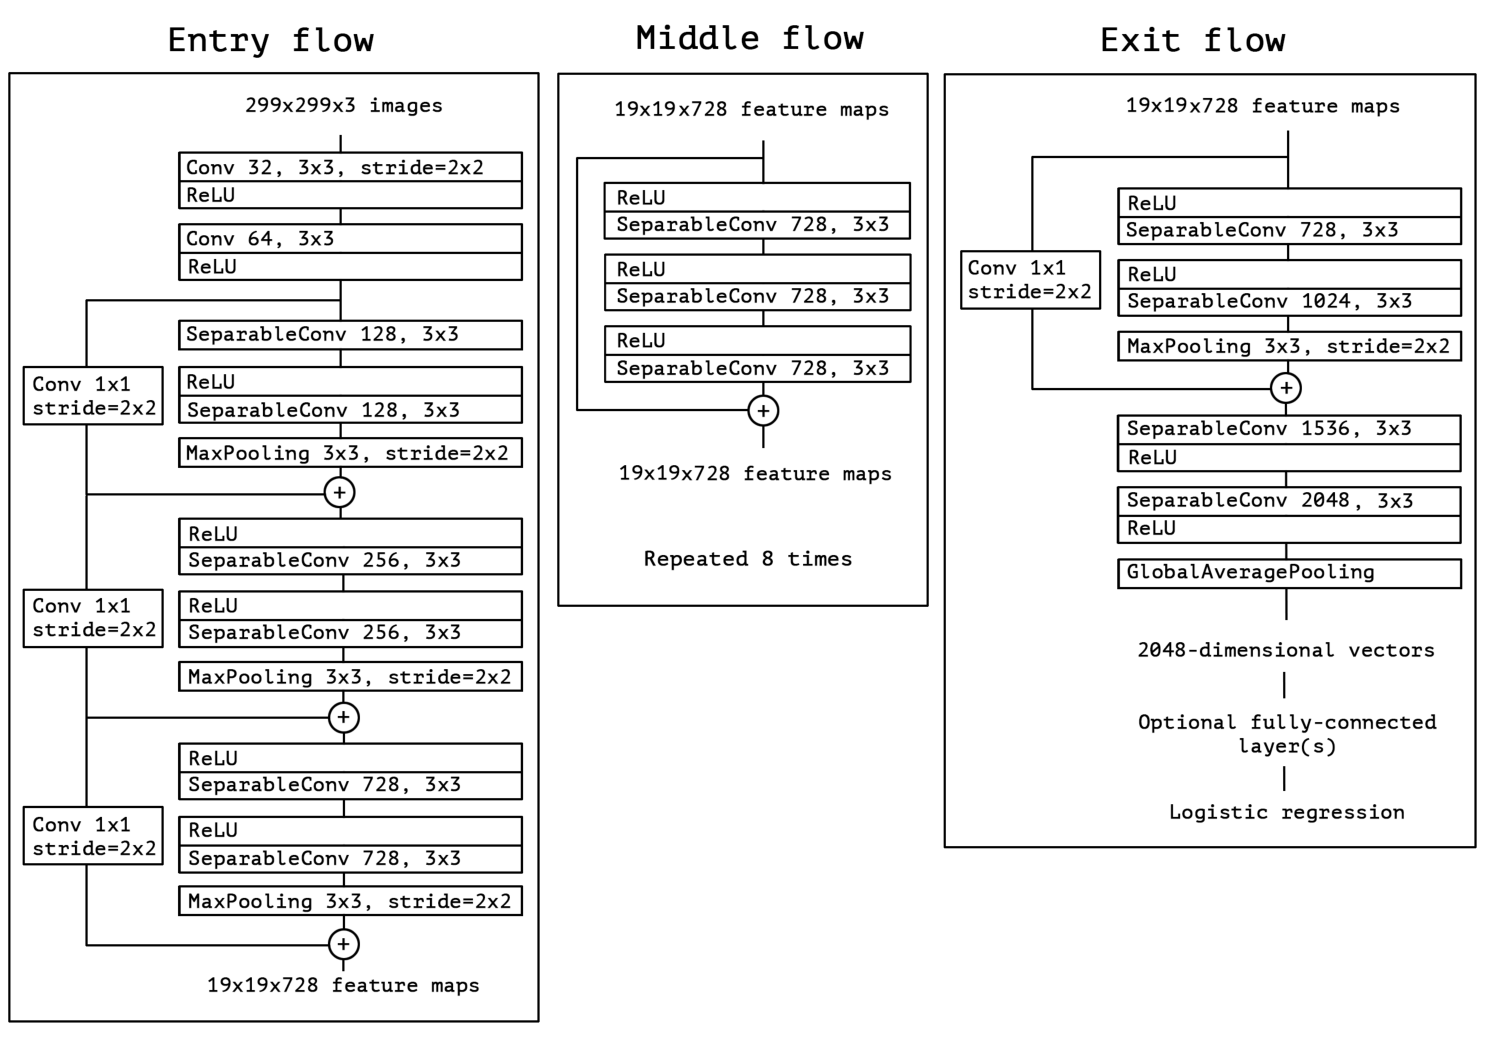
其中SeparableConv 由的3x3 depthwise卷积和的1x1 pointwise卷积组成  
注意图中所有的Conv 和SeparableConv层后面都跟着一个BatchNorm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,random_split
import os
import numpy as np
import pandas as pd
from einops import rearrange,reduce,repeat
from einops.layers.torch import EinMix as Mix
from einops.layers.torch import Rearrange,Reduce
import random

def set_seed(seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

In [52]:
def SeparableConv(input_channel,output_channel):
  block = nn.Sequential(
      nn.Conv2d(input_channel,input_channel,(3,3),padding=1,groups=input_channel,bias=False),
      nn.Conv2d(input_channel,output_channel,(1,1),bias=False),
  )
  return block

class SeparableBlock1(nn.Module):
  def __init__(self,input_channel,bottleneck_channel,output_channel,first_relu=True):
    super(SeparableBlock1,self).__init__()
    self.skip = nn.Conv2d(input_channel,output_channel,(1,1),stride=(2,2),bias=False)
    self.skipbn = nn.BatchNorm2d(output_channel)
    if first_relu:

      self.rep = nn.Sequential(
          nn.ReLU(inplace=True),
          SeparableConv(input_channel,bottleneck_channel),
          nn.BatchNorm2d(bottleneck_channel),
          nn.ReLU(inplace=True),
          SeparableConv(bottleneck_channel,output_channel),
          nn.BatchNorm2d(output_channel),
          nn.MaxPool2d((3,3),stride = (2,2) ,padding=1)
      )
    else:
      self.rep = nn.Sequential(
          #nn.ReLU(inplace=True),
          SeparableConv(input_channel,bottleneck_channel),
          nn.BatchNorm2d(bottleneck_channel),
          nn.ReLU(inplace=True),
          SeparableConv(bottleneck_channel,output_channel),
          nn.BatchNorm2d(output_channel),
          nn.MaxPool2d((3,3),stride = (2,2),padding=1)
      )
  def forward(self,x):
    x = self.skipbn(self.skip(x)) + self.rep(x)
    return x
  
class SeparableBlock2(nn.Module):
  def __init__(self,input_channel):
    super(SeparableBlock2,self).__init__()
    self.rep = nn.Sequential(
          nn.ReLU(inplace=True),
          SeparableConv(input_channel,input_channel),
          nn.BatchNorm2d(input_channel),
          nn.ReLU(inplace=True),
          SeparableConv(input_channel,input_channel),
          nn.BatchNorm2d(input_channel),
          nn.ReLU(inplace=True),
          SeparableConv(input_channel,input_channel),
          nn.BatchNorm2d(input_channel),
      )
  def forward(self,x):
    x = x + self.rep(x)
    return x

class Xception(nn.Module):
   def __init__(self,input_channel,num_class = 1000):
     super(Xception,self).__init__()
     self.Entry_flow = nn.Sequential(
         nn.Conv2d(input_channel,32,(3,3),stride=2,bias=False),
         nn.BatchNorm2d(32),
         nn.ReLU(inplace=True),
         nn.Conv2d(32,64,(3,3),bias=False),
         nn.BatchNorm2d(64),
         nn.ReLU(inplace=True),
         
         SeparableBlock1(64,128,128,False),
         SeparableBlock1(128,256,256),
         SeparableBlock1(256,728,728),
         )
     self.Middle_flow = nn.Sequential(
         *[SeparableBlock2(728) for i in range(8)]
      )
     self.Exit_flow = nn.Sequential(
         SeparableBlock1(728,728,1024),
         SeparableConv(1024,1536),
         nn.BatchNorm2d(1536),
         nn.ReLU(inplace=True),

         SeparableConv(1536,2048),
         nn.BatchNorm2d(2048),
         nn.ReLU(inplace=True),

         Reduce('b c h w -> b c','mean')


      )
     self.head = nn.Linear(2048,num_class)
   def _feature_map(self,x):
     x = self.Entry_flow(x)
     x = self.Middle_flow(x)
     x = self.Exit_flow(x)
     return x
   
   def forward(self,x):
    x = self._feature_map(x)
    x = self.head(x)
    return x




# 实例化Xception模型 并和timm中定义的模型对比

In [62]:
model =Xception(3)

In [64]:
torchstat.stat(model,(3,299,299))

[MAdd]: Reduce is not supported!
[Flops]: Reduce is not supported!
[Memory]: Reduce is not supported!
[MAdd]: Reduce is not supported!
[Flops]: Reduce is not supported!
[Memory]: Reduce is not supported!
                 module name   input shape  output shape      params memory(MB)              MAdd            Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0               Entry_flow.0     3 299 299    32 149 149       864.0       2.71      37,652,896.0     19,181,664.0   1076268.0    2841728.0       0.49%    3917996.0
1               Entry_flow.1    32 149 149    32 149 149        64.0       2.71       2,841,728.0      1,420,864.0   2841984.0    2841728.0       0.20%    5683712.0
2               Entry_flow.2    32 149 149    32 149 149         0.0       2.71         710,432.0        710,432.0   2841728.0    2841728.0       0.10%    5683456.0
3               Entry_flow.3    32 149 149    64 147 147     18432.0       5.28     795,211,200.0    398,297,088.0   2915456.0    553190

In [61]:
model_ = timm.create_model('xception')
torchstat.stat(model_,(3,299,299))

[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: AdaptiveAvgPool2d is not supported!
[Flops]: AdaptiveAvgPool2d is not supported!
[Memory]: AdaptiveAvgPool2d is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
[MAdd]: Flatten is not supported!
[Flops]: Flatten is not supported!
[Memory]: Flatten is not supported!
                   module name   input shape  output shape      params memory(MB)              MAdd            Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0                        conv1     3 299 299    32 149 149       864.0       2.71      37,652,896.0     19,181,664.0   1076268.0    2841728.0       0.50%    3917996.0
1                          bn1    32 149 149    32 149 149        64.0       2.71       2,841,728.0      1,420,864.0   2841984.0    2841728.0       0.16%    5683712.0
2                  